When exploring a large set of documents -- such as Wikipedia, news articles, StackOverflow, etc. -- it can be useful to get a list of related material. To find relevant documents you typically
* Decide on a notion of similarity
* Find the documents that are most similar 

In the assignment you will
* Gain intuition for different notions of similarity and practice finding similar documents. 
* Explore the tradeoffs with representing documents using raw word counts and TF-IDF
* Explore the behavior of different distance metrics by looking at the Wikipedia pages most similar to President Obama’s page.

In [79]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

## Load Wikipedia dataset

We will be using the dataset of abridged Wikipedia pages. Each element of the dataset consists of a link to the wikipedia article, the name of the person, and the text of the article (in lowercase).  

In [80]:
wiki = pd.read_csv('people_wiki.csv')
wiki.head()

,URI,name,text
0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former australian rules footballer who played with the kangaroos and carlton in the australian football league aflfrom western australia morrell played his early senior football for west perth his 44game senior career for the falcons spanned 19982000 and he was the clubs leading goalkicker in 2000 at the age of 21 morrell was recruited to the australian football league by the kangaroos football club with its third round selection in the 2001 afl rookie draft as a forward he twice kicked five goals during his time with the kangaroos the first was in a losing cause against sydney in 2002 and the other the following season in a drawn game against brisbaneafter the 2003 season morrell was traded along with david teague to the carlton football club in exchange for corey mckernan he played 32 games for the blues before being delisted at the end of 2005 he continued to play victorian football league vfl football with the northern bullants carltons vflaffiliate in 2006 and acted as playing assistant coach in 2007 in 2008 he shifted to the box hill hawks before retiring from playing at the end of the season from 2009 until 2013 morrell was the senior coach of the strathmore football club in the essendon district football league leading the club to the 2011 premier division premiership since 2014 he has coached the west coburg football club also in the edflhe currently teaches physical education at parade college in melbourne
1,<http://dbpedia.org/resource/Alfred_J._Lewy>,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from university of chicago in 1973 after studying psychiatry pharmacology and ophthalmology he is a full professor and vicechair of the department of psychiatry at ohsu oregon health science university and holds an md and phd prior to moving to oregon in 1981 lewy was at the national institute of mental health nimh in bethesda maryland working with senior colleague thomas wehr in oregon he has worked closely with robert l sack as of december 2005 he had 94 publications available on pubmed he describes his research as follows my laboratory studies chronobiologic sleep and mood disorders these disorders include winter depression jet lag maladaptation to shift work and certain types of sleep disturbances relying on a very precise assay for plasma melatonin a hormone that has a clearly defined 24hour pattern of secretion biological rhythm disorders can be assessed and their treatment can be monitored current research is focused on developing bright light exposure and melatonin administration as treatment modalities for these disorders treatment must be precisely scheduled morning light exposure and evening melatonin administration cause circadian phaseadvance shifts evening light exposure and morning melatonin administration cause circadian phasedelay shifts totally blind individuals have 25hour circadian rhythms drifting an hour later each day unless they take a melatonin capsule at a certain time every day
2,<http://dbpedia.org/resource/Harpdog_Brown>,Harpdog Brown,harpdog brown is a singer and harmonica player who has been active in canadas blues scene since 1982 hailing from vancouver he crossed tens of thousands of miles playing club dates and festivals in canada the northwestern united states and germanyover the years he has issued seven cds in 1995 his home is where the harp is won the muddy award for the best nw blues release from the cascade blues association in portland oregon as well that year it was nominated for a canadian juno for the best bluesgospel recording teamed up with graham guest on piano his cd naturally was voted 1 canadian blues album of 2010 by the blind lemon surveybrown tours extensively with his guitarist j arthur edmonds performing their electric mid1950s chicago blues either as a duo or with the full band while he is home he juggles a few combos working many venues big and sm

If you want to check whether the text on the webpage agrees with the one here, you can display it with the following code:

In [81]:
# from IPython.display import HTML
# print(wiki['text'][0])
# HTML(url=wiki['URI'][0])

## Ex. 1: Extract word count vectors

As we have seen in Assignment 4, we can extract word count vectors using `CountVectorizer` function.
- make sure you include words of unit length by using the parameter: `token_pattern=r"(?u)\b\w+\b"`
- do not use any stopwords
- take 10000 most frequent words in the corpus
- explicitly take all the words independent of in how many documents they occur
- obtain the matrix of word counts

In [82]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(
    token_pattern=r"(?u)\b\w+\b",
    max_features=10000,
    stop_words = None,
    min_df=0.0)
WCmatrix = vectorizer.fit_transform(wiki['text'])

## Ex. 2: Find nearest neighbors

**a)** Start by finding the nearest neighbors of the Barack Obama page using the above word count matrix to represent the articles and **Euclidean** distance to measure distance.
Save the distances in `wiki['BO-eucl']` and look at the top 10 nearest neighbors.

In [83]:
# One can use the following:
    # from sklearn.neighbors import NearestNeighbors
    # nbrs = NearestNeighbors(n_neighbors=3, algorithm='brute',metric='euclidean').fit(X.toarray())
    # distances, indices = nbrs.kneighbors(X.toarray())
# but here let's use:
from sklearn.metrics import pairwise_distances

dist = pairwise_distances(WCmatrix, WCmatrix[wiki[wiki['name'] == 'Barack Obama'].index[0]])
wiki['BO-eucl'] = dist



In [84]:
wiki.sort_values(by='BO-eucl',ascending=True)[0:10]

,URI,name,text,BO-eucl
35811,<http://dbpedia.org/resource/Barack_Obama>,Barack Obama,barack hussein obama ii brk husen bm born august 4 1961 is the 44th and current president of the united states and the first african american to hold the office born in honolulu hawaii obama is a graduate of columbia university and harvard law school where he served as president of the harvard law review he was a community organizer in chicago before earning his law degree he worked as a civil rights attorney and taught constitutional law at the university of chicago law school from 1992 to 2004 he served three terms representing the 13th district in the illinois senate from 1997 to 2004 running unsuccessfully for the united states house of representatives in 2000in 2004 obama received national attention during his campaign to represent illinois in the united states senate with his victory in the march democratic party primary his keynote address at the democratic national convention in july and his election to the senate in november he began his presidential campaign in 2007 and after a close primary campaign against hillary rodham clinton in 2008 he won sufficient delegates in the democratic party primaries to receive the presidential nomination he then defeated republican nominee john mccain in the general election and was inaugurated as president on january 20 2009 nine months after his election obama was named the 2009 nobel peace prize laureateduring his first two years in office obama signed into law economic stimulus legislation in response to the great recession in the form of the american recovery and reinvestment act of 2009 and the tax relief unemployment insurance reauthorization and job creation act of 2010 other major domestic initiatives in his first term included the patient protection and affordable care act often referred to as obamacare the doddfrank wall street reform and consumer protection act and the dont ask dont tell repeal act of 2010 in foreign policy obama ended us military involvement in the iraq war increased us troop levels in afghanistan signed the new start arms control treaty with russia ordered us military involvement in libya and ordered the military operation that resulted in the death of osama bin laden in january 2011 the republicans regained control of the house of representatives as the democratic party lost a total of 63 seats and after a lengthy debate over federal spending and whether or not to raise the nations debt limit obama signed the budget control act of 2011 and the american taxpayer relief act of 2012obama was reelected president in november 2012 defeating republican nominee mitt romney and was sworn in for a second term on january 20 2013 during his second term obama has promoted domestic policies related to gun control in response to the sandy hook elementary school shooting and has called for full equality for lgbt americans while his administration has filed briefs which urged the supreme court to strike down the defense of marriage act of 1996 and californias proposition 8 as unconstitutional in foreign policy obama ordered us military involvement in iraq in response to gains made by the islamic state in iraq after the 2011 withdrawal from iraq continued the process of ending us combat operations in afghanistan and has sought to normalize us relations with cuba,0.000000
24478,<http://dbpedia.org/resource/Joe_Biden>,Joe Biden,joseph robinette joe biden jr dosf rbnt badn born november 20 1942 is the 47th and current vice president of the united states jointly elected with president barack obama he is a member of the democratic party and was a united states senator from delaware from january 3 1973 until his resignation on january 15 2009 following his election to the vice presidency in 2012 biden was elected to a second term alongside obamabiden was born in scranton pennsylvania and lived there for ten years before moving to delaware he became an attorney in 1969 and was elected to the n

**b)** Measure the pairwise distance between the Wikipedia pages of Barack Obama, George W. Bush, and Joe Biden. Which of the three pairs has the smallest distance?

In [85]:
dist = pairwise_distances(WCmatrix, WCmatrix[wiki[wiki['name'] == 'George W. Bush'].index[0]])
bush_obama = dist[wiki[wiki['name'] == 'Barack Obama'].index[0]]
bush_biden = dist[wiki[wiki['name'] == 'Joe Biden'].index[0]]
dist = pairwise_distances(WCmatrix, WCmatrix[wiki[wiki['name'] == 'Joe Biden'].index[0]])
biden_obama = dist[wiki[wiki['name'] == 'Barack Obama'].index[0]]
print(bush_obama, bush_biden, biden_obama)

[33.63034344] [30.91924967] [31.32091953]


All of the 10 people from **a)** are politicians, but about half of them have rather tenuous connections with Obama, other than the fact that they are politicians, e.g.,

* Francisco Barrio is a Mexican politician, and a former governor of Chihuahua.
* Walter Mondale and Don Bonker are Democrats who made their career in late 1970s.

Nearest neighbors with raw word counts got some things right, showing all politicians in the query result, but missed finer and important details.

**c)** Let's find out why Francisco Barrio was considered a close neighbor of Obama.
To do this, look at the most frequently used words in each of Barack Obama and Francisco Barrio's pages.

In [86]:
def top_words(name):
    """
    Get a table of the most frequent words in the given person's wikipedia page.
    """
    # Your code goes here
    df = pd.DataFrame({'word': vectorizer.get_feature_names_out(), 'count': WCmatrix[wiki[wiki['name'] == name].index[0]].toarray()[0]})
    
    return df.sort_values(by='count',ascending=False)

In [87]:
obama_words = top_words('Barack Obama')
obama_words

,word,count
9063,the,40
4622,in,30
723,and,21
6381,of,18
9161,to,14
...,...,...
3376,europa,0
3377,europe,0
3378,european,0
3379,europes,0


In [88]:
barrio_words = top_words('Francisco Barrio')
barrio_words

,word,count
9063,the,36
6381,of,24
723,and,18
4622,in,17
4291,he,10
...,...,...
3366,eternal,0
3367,ethical,0
3368,ethics,0
3369,ethiopia,0


**d)** Extract the list of most frequent **common** words that appear in both Obama's and Barrio's documents and display the five words that appear most often in Barrio's article.

Use a dataframe operation known as **join**. The **join** operation is very useful when it comes to playing around with data: it lets you combine the content of two tables using a shared column (in this case, the index column of words). See [the documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html) for more details.

In [89]:
# Modify the code to avoid error.

common_words = obama_words.join(barrio_words, lsuffix='_Obama', rsuffix='_Barrio')
common_words.sort_values(by='count_Barrio', ascending=False).head(5)[['word_Barrio', 'count_Barrio']]

,word_Barrio,count_Barrio
9063,the,36
6381,of,24
723,and,18
4622,in,17
4291,he,10


Collect all words that appear both in Barack Obama and George W. Bush pages.  Out of those words, find the 10 words that show up most often in Obama's page. 

In [90]:
bush_words = top_words('George W. Bush')
# Modify the code to avoid error.
obama_words = obama_words.join(bush_words, lsuffix='_Obama', rsuffix='_Bush')
obama_words.sort_values(by='count_Obama', ascending=False).head(10)[['word_Obama', 'count_Obama']]


,word_Obama,count_Obama
9063,the,40
4622,in,30
723,and,21
6381,of,18
9161,to,14
4392,his,11
6346,obama,9
454,act,8
370,a,7
4291,he,7


**Note.** Even though common words are swamping out important subtle differences, commonalities in rarer political words still matter on the margin. This is why politicians are being listed in the query result instead of musicians, for example. In the next subsection, we will introduce a different metric that will place greater emphasis on those rarer words.

**e)** Among the words that appear in both Barack Obama and Francisco Barrio, take the 15 that appear most frequently in Obama. How many of the articles in the Wikipedia dataset contain all of those 15 words? Which are they?

In [91]:
# It might be helpful to use:
word_to_ind={v: i for i, v in enumerate(vectorizer.get_feature_names_out())}

# Your code goes here 
common_words = common_words.sort_values(by='count_Obama', ascending=False).head(15)
word_indices = [word_to_ind[word] for word in common_words['word_Obama']]
matrix_slice = WCmatrix[:, word_indices].toarray()

articles = (WCmatrix[:, word_indices].toarray() > 0).all(axis=1)
articles.su

AttributeError: 'numpy.ndarray' object has no attribute 'su'

In [92]:
wiki[articles]['name']

13509    James S. Bubar
17184    Marty Lederman
24478         Joe Biden
30798    Richard Pildes
35811      Barack Obama
Name: name, dtype: object

## Ex. 3: TF-IDF to the rescue

Much of the perceived commonalities between Obama and Barrio were due to occurrences of extremely frequent words, such as "the", "and", and "his". So nearest neighbors is recommending plausible results sometimes for the wrong reasons.

To retrieve articles that are more relevant, we should focus more on rare words that don't happen in every article. **TF-IDF** (term frequency–inverse document frequency) is a feature representation that penalizes words that are too common.

**a)** Repeat the search for the 10 nearest neighbors of Barack Obama with Euclidean distance of TF-IDF. This time do not limit to only 10000 most frequent words, but take all of them.

In [93]:
# We could use:
    # from sklearn.feature_extraction.text import TfidfVectorizer
# but since we already know how to compute CountVectorizer, let's use:
from sklearn.feature_extraction.text import TfidfTransformer

vectorizer = CountVectorizer(
    token_pattern=r"(?u)\b\w+\b",
    stop_words = None,
    min_df=0.0
                            )
WCmatrix=vectorizer.fit_transform(wiki['text'])

tfidf=TfidfTransformer(smooth_idf=False, norm=None)# Your code goes here; use smooth_idf=False, norm=None
TFIDFmatrix = tfidf.fit_transform(WCmatrix)

In [94]:
# now recompute the distances as before but for TF-IDF
dist = pairwise_distances(
    TFIDFmatrix,
    TFIDFmatrix[wiki[wiki['name'] == 'Barack Obama'].index[0]]
                        )
# add the distances as a column in the wiki dataframe
wiki['BO-eucl-TF-IDF'] = dist
wiki.sort_values(by='BO-eucl-TF-IDF',ascending=True)[0:10][['name','BO-eucl-TF-IDF']]


,name,BO-eucl-TF-IDF
35811,Barack Obama,0.000000
38370,Samantha Power,139.112650
7914,Phil Schiliro,139.607641
38708,Eric Stern (politician),140.329584
6507,Bob Menendez,141.720287
6796,Eric Holder,142.271700
38489,Barney Frank,142.688155
33411,Tulsi Gabbard,142.876495
7950,Elizabeth Warren,143.092814
40093,Harry Arthurs,143.390437


Let's determine whether this list makes sense.
* With a notable exception of Nathan Cullen, the other 8 are all American politicians who are contemporaries of Barack Obama.
* Phil Schiliro, Jesse Lee, Samantha Power, Eric Stern, Eric Holder worked for Obama.

Clearly, the results are more plausible with the use of TF-IDF. Let's take a look at the word vector for Obama and Schilirio's pages. Notice that TF-IDF representation assigns a weight to each word. This weight captures relative importance of that word in the document.

**b)** Sort the words in Obama's article by their TF-IDF weights; do the same for Schiliro's article as well.
Using the **join** operation we learned earlier, compute the common words shared by Obama's and Schiliro's articles.
Sort the common words by their TF-IDF weights in Obama's document.

In [95]:
def top_words_tf_idf(name):
    """
    Get a table of the largest tf-idf words in the given person's wikipedia page.
    """
    # Your code goes here
    df = pd.DataFrame({'word': vectorizer.get_feature_names_out(), 'tf-idf': TFIDFmatrix[wiki[wiki['name'] == name].index[0]].toarray()[0]})
    return df.sort_values(by='tf-idf',ascending=False)

In [96]:
obama_tf_idf = top_words_tf_idf('Barack Obama')
schiliro_tf_idf = top_words_tf_idf('Phil Schiliro')
common_words = obama_tf_idf.join(schiliro_tf_idf, lsuffix='_Obama', rsuffix='_Schiliro')

**c)** Among the words that appear in both Barack Obama and Phil Schiliro, take the 15 that have largest weights in Obama. How many of the articles in the Wikipedia dataset contain all of those 15 words? Which are they?

In [97]:
# It might be helpful to use:
word_to_ind={v: i for i, v in enumerate(vectorizer.get_feature_names_out())} # a dictionary with words as keys and indices as values

# Your code goes here
common_words = common_words.sort_values(by='tf-idf_Obama', ascending=False).head(15)
word_indices = [word_to_ind[word] for word in common_words['word_Obama']]
articles = (TFIDFmatrix[:, word_indices].toarray() > 0).all(axis=1)
articles.sum()

1

In [98]:
wiki[articles]['name']

35811    Barack Obama
Name: name, dtype: object

Notice the huge difference in this calculation using TF-IDF scores instead  of raw word counts. We've eliminated noise arising from extremely common words.

## Ex. 4: Choosing metrics

**a)** Compute the Euclidean distance between TF-IDF features of Obama and Biden.

In [22]:
dist = pairwise_distances(TFIDFmatrix[wiki[wiki['name'] == 'Barack Obama'].index[0]], TFIDFmatrix[wiki[wiki['name'] == 'Joe Biden'].index[0]])
dist

array([[147.88506796]])

The distance is larger than the distances we found for the 10 nearest neighbors, which we repeat here for readability:

In [99]:
wiki.sort_values(by='BO-eucl-TF-IDF',ascending=True)[['name','BO-eucl-TF-IDF']][0:10]

,name,BO-eucl-TF-IDF
35811,Barack Obama,0.000000
38370,Samantha Power,139.112650
7914,Phil Schiliro,139.607641
38708,Eric Stern (politician),140.329584
6507,Bob Menendez,141.720287
6796,Eric Holder,142.271700
38489,Barney Frank,142.688155
33411,Tulsi Gabbard,142.876495
7950,Elizabeth Warren,143.092814
40093,Harry Arthurs,143.390437


But one may wonder, is Biden's article that different from Obama's, more so than, say, Schiliro's? It turns out that, when we compute nearest neighbors using the Euclidean distances, we unwittingly favor short articles over long ones.

**b)** Let us compute the length of each Wikipedia document, and examine the document lengths for the 100 nearest neighbors to Obama's page. To compute text length use the same splitting rules you used in `vectorizer`.

In [100]:
tokenizer = vectorizer.build_tokenizer()

def compute_length(row):
# Here we could use simply:
#     return len(row['text'].split(' '))
    return len(tokenizer(row['text']))

wiki['length'] = wiki.apply(compute_length, axis=1)

In [101]:
nearest_neighbors_euclidean = wiki.sort_values(by='BO-eucl-TF-IDF',ascending=True)[0:100]
nearest_neighbors_euclidean[['name', 'length']]

,name,length
35811,Barack Obama,540
38370,Samantha Power,310
7914,Phil Schiliro,208
38708,Eric Stern (politician),255
6507,Bob Menendez,220
...,...,...
14442,Lee Hawkins,212
6924,D. Brock Hornby,205
15850,Mark Strauss (journalist),225
41680,Marian Blank Horn,229


**c)** To see how these document lengths compare to the lengths of other documents in the corpus, make a histogram of the document lengths of Obama's 100 nearest neighbors and compare to a histogram of document lengths for all documents.

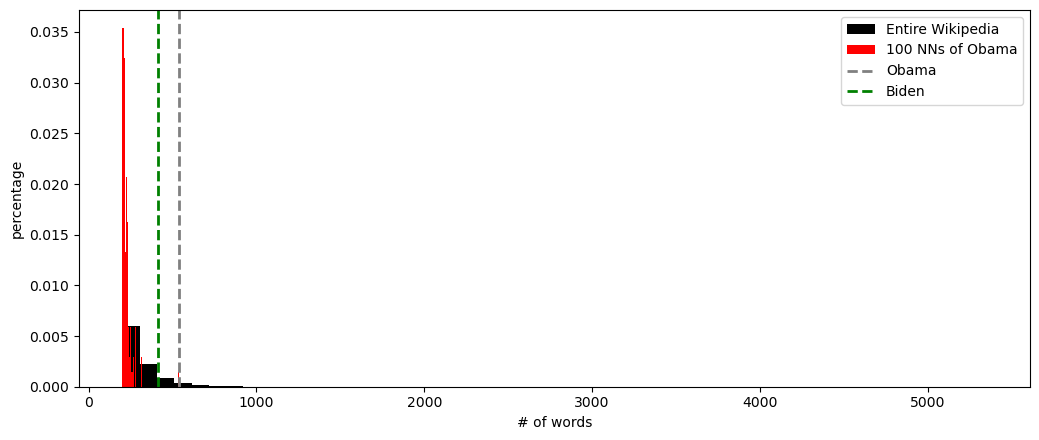

In [102]:
plt.figure(figsize=(10.5,4.5))
plt.xlabel('# of words')
plt.ylabel('percentage')
plt.hist(wiki['length'], 50, color='k', edgecolor='none', histtype= 'stepfilled', label='Entire Wikipedia', density=True)
plt.hist(nearest_neighbors_euclidean['length'], 50, color='r', edgecolor='none', histtype= 'stepfilled', label='100 NNs of Obama', density=True)
plt.axvline(wiki['length'][wiki['name'] == 'Barack Obama'].values[0], color='grey', linestyle='--', linewidth=2, label='Obama')
plt.axvline(wiki['length'][wiki['name'] == 'Joe Biden'].values[0], color='g', linestyle='--', linewidth=2, label='Biden')

plt.legend()

plt.tight_layout()

Relative to the rest of Wikipedia, nearest neighbors of Obama are overwhemingly short, most of them being shorter than 300 words. The bias towards short articles is not appropriate in this application as there is really no reason to  favor short articles over long articles (they are all Wikipedia articles, after all). Many of the Wikipedia articles are 300 words or more, and both Obama and Biden are over 300 words long.

**Note**: For the interest of computation time, the dataset given here contains _excerpts_ of the articles rather than full text. For instance, the actual Wikipedia article about Obama is around 25000 words. Do not be surprised by the low numbers shown in the histogram.

**Note:** Both word-count features and TF-IDF are proportional to word frequencies. While TF-IDF penalizes very common words, longer articles tend to have longer TF-IDF vectors simply because they have more words in them.

To remove this bias, we turn to **cosine distances**:
$$
d(\mathbf{x},\mathbf{y}) = 1 - \frac{\mathbf{x}^T\mathbf{y}}{\|\mathbf{x}\| \|\mathbf{y}\|}
$$
Cosine distances let us compare word distributions of two articles of varying lengths.

**d)** Train a new nearest neighbor model, this time with cosine distances.  Then repeat the search for Obama's 100 nearest neighbors and make a plot to better visualize the effect of having used cosine distance in place of Euclidean on our TF-IDF vectors.

In [103]:
# Your code goes here
dist = pairwise_distances(TFIDFmatrix, TFIDFmatrix[wiki[wiki['name'] == 'Barack Obama'].index[0]], metric='cosine')
wiki['BO-cos'] = dist
nearest_neighbors_cosine = wiki.sort_values(by='BO-cos',ascending=True)[0:100][['name', 'length', 'BO-cos']]
nearest_neighbors_cosine

,name,length,BO-cos
35811,Barack Obama,540,3.330669e-16
24478,Joe Biden,414,5.689319e-01
38370,Samantha Power,310,6.231093e-01
38708,Eric Stern (politician),255,6.499863e-01
28441,George W. Bush,505,6.600595e-01
...,...,...,...
5248,Eric L. Muller,443,7.408212e-01
21004,Herschel Hardin,551,7.411900e-01
40937,Jonathan Alter,283,7.416125e-01
27570,Luis Maldonado Venegas,509,7.418427e-01


From a glance at the above table, things look better.  For example, we now see Joe Biden as Barack Obama's nearest neighbor!  We also see Hillary Clinton on the list.  This list looks even more plausible as nearest neighbors of Barack Obama.

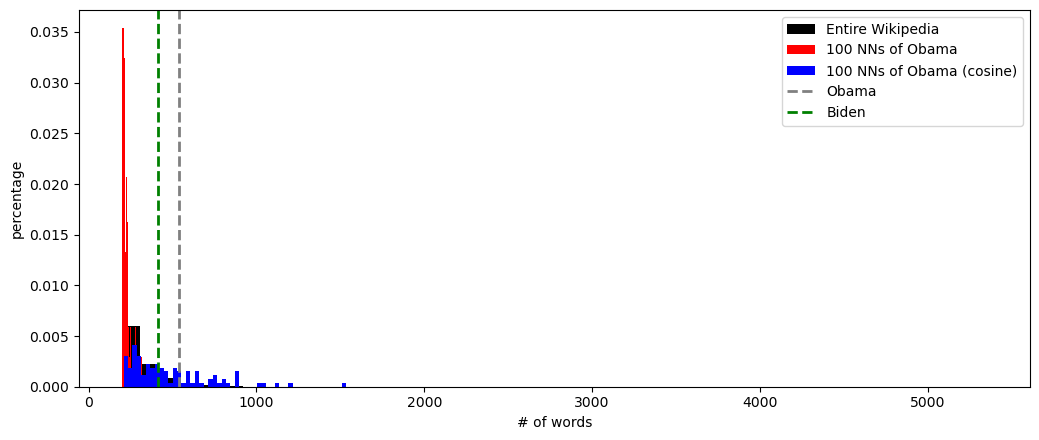

In [104]:
plt.figure(figsize=(10.5,4.5))
plt.xlabel('# of words')
plt.ylabel('percentage')
plt.hist(wiki['length'], 50, color='k', edgecolor='none', histtype= 'stepfilled', label='Entire Wikipedia', density=True)
plt.hist(nearest_neighbors_euclidean['length'], 50, color='r', edgecolor='none', histtype= 'stepfilled', label='100 NNs of Obama', density=True)
plt.hist(nearest_neighbors_cosine['length'], 50, color='b', edgecolor='none', histtype= 'stepfilled', label='100 NNs of Obama (cosine)', density=True)
plt.axvline(wiki['length'][wiki['name'] == 'Barack Obama'].values[0], color='grey', linestyle='--', linewidth=2, label='Obama')
plt.axvline(wiki['length'][wiki['name'] == 'Joe Biden'].values[0], color='g', linestyle='--', linewidth=2, label='Biden')

plt.legend()

plt.tight_layout()

Indeed, the 100 nearest neighbors using cosine distance provide a sampling across the range of document lengths, rather than just short articles like Euclidean distance provided.

**Moral of the story**: In deciding the features and distance measures, check if they produce results that make sense for your particular application.

## Ex. 5: Problem with cosine distances: tweets vs. long articles

Happily ever after? Not so fast. Cosine distances ignore all document lengths, which may be great in certain situations but not in others. For instance, consider the following (admittedly contrived) example.

```
+--------------------------------------------------------+
|                                             +--------+ |
|  One that shall not be named                | Follow | |
|  @username                                  +--------+ |
|                                                        |
|  Democratic governments control law in response to     |
|  popular act.                                          |
|                                                        |
|  8:05 AM - 16 May 2016                                 |
|                                                        |
|  Reply   Retweet (1,332)   Like (300)                  |
|                                                        |
+--------------------------------------------------------+
```

**a)** Transform the tweet into TF-IDF features, using the fit to the Wikipedia dataset. (That is, let's treat this tweet as an article in our Wikipedia dataset and see what happens.) How similar is this tweet to Barack Obama's Wikipedia article? 

In [108]:
df = pd.DataFrame({'text': ['democratic governments control law in response to popular act']})
WCmatrix_sentence = vectorizer.transform(df['text'])
TFIDF_sentence = tfidf.transform(WCmatrix_sentence)

# Pobranie słownika cech
vocabulary = vectorizer.get_feature_names_out()

# Wyciągnięcie wartości TF-IDF dla każdego słowa w zdaniu
feature_names = pd.Series(vocabulary)
sentence_tfidf = TFIDF_sentence.toarray()[0]  # Konwersja na gęstą tablicę, bo to pojedynczy wektor

# Dopasowanie słów ze zdania do ich indeksów i wartości TF-IDF
word_tfidf_values = {
    word: sentence_tfidf[feature_names[feature_names == word].index[0]]
    for word in df['text'][0].split()
    if word in feature_names.values
}

# Wyświetlenie wyniku w formie tabeli
result_df = pd.DataFrame(
    [
        {"word": word, "count": 1, "tfidf_value": tfidf_value}
        for word, tfidf_value in word_tfidf_values.items()
    ]
)
result_df
# Your code goes here

,word,count,tfidf_value
0,democratic,1,4.100766
1,governments,1,5.150736
2,control,1,4.730543
3,law,1,3.453298
4,in,1,1.001076
5,response,1,5.268705
6,to,1,1.046378
7,popular,1,3.766298
8,act,1,4.434127


Let's compare this tweet's TF-IDF vectors  to Barack Obama's Wikipedia entry.

In [111]:
obama_tf_idf

,word,tf-idf
285825,obama,52.811176
389496,the,40.005610
35036,act,35.473020
200589,in,30.032271
206488,iraq,21.741821
...,...,...
145890,ert,0.000000
145889,ersz,0.000000
145888,erstwhile,0.000000
145887,erster,0.000000


**b)** Now, compute the cosine distance between the Barack Obama article and this tweet:

In [113]:
from sklearn.metrics.pairwise import cosine_distances # for one pair of samples we can just use this function
dist = cosine_distances(TFIDF_sentence, TFIDFmatrix[wiki[wiki['name'] == 'Barack Obama'].index[0]])
dist
# Your code goes here

array([[0.69925755]])

Let's compare this distance to the distance between the Barack Obama article and all of its Wikipedia nearest neighbors:

In [114]:
nearest_neighbors_cosine[0:23]

,name,length,BO-cos
35811,Barack Obama,540,3.330669e-16
24478,Joe Biden,414,5.689319e-01
38370,Samantha Power,310,6.231093e-01
38708,Eric Stern (politician),255,6.499863e-01
28441,George W. Bush,505,6.600595e-01
39351,John McCain,410,6.601311e-01
18827,Henry Waxman,279,6.702800e-01
37193,Barry Sullivan (lawyer),893,6.731467e-01
6796,Eric Holder,232,6.750291e-01
36446,Bill Clinton,524,6.752721e-01


With cosine distances, the tweet is "nearer" to Barack Obama than most people! If someone is reading the Barack Obama Wikipedia page, would you want to recommend they read this tweet?
In practice, it is common to enforce maximum or minimum document lengths. After all, when someone is reading a long article from _The Atlantic_, you wouldn't recommend him/her a tweet.